In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import keras
from keras.models import Model,Sequential
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, BatchNormalization, Dropout
from keras import regularizers
from keras.optimizers import SGD
from clr_callback import *
%matplotlib inline


Using TensorFlow backend.


In [2]:
# Useful Constants

# Output classes to learn how to classify
LABELS = [    
    "JUMPING",
    "JUMPING_JACKS",
    "BOXING",
    "WAVING_2HANDS",
    "WAVING_1HAND",
    "CLAPPING_HANDS"

] 
DATASET_PATH = "data/"

x_train_path = DATASET_PATH + "X_train.csv"
x_test_path = DATASET_PATH + "X_test.csv"
y_train_path = DATASET_PATH + "Y_train.csv"
y_test_path = DATASET_PATH + "Y_test.csv"


n_steps = 32    # 32 frames per series

In [3]:
def load_X(path):
    data=pd.read_csv(path,header=None).values
    blocks = int(len(data) / n_steps)
    data=np.array(np.split(data,blocks))
    return data

def load_y(path):
    data=pd.read_csv(path,header=None).values
    return data-1

In [4]:
#Load the data
X_train = load_X(x_train_path)
X_test = load_X(x_test_path)
y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [5]:
# Input Data 
training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])
n_hidden = 36 # Hidden layer num of features
n_classes = 6  #number of action classes

batch_size = 256


In [6]:
y_train_one_hot = to_categorical(y_train, num_classes=6)
y_test_one_hot = to_categorical(y_test, 6)

train_size = X_train.shape[0] - X_train.shape[0] % batch_size
test_size = X_test.shape[0] - X_test.shape[0] % batch_size

In [7]:
model = Sequential([
   # relu activation
   Dense(n_hidden, activation='relu'
   ),
   BatchNormalization(), 
   LSTM(n_hidden, return_sequences=True,  unit_forget_bias=1.0,dropout=0.2),
   LSTM(n_hidden,  unit_forget_bias=1.0),
   BatchNormalization(), 
   Dense(n_classes,
       activation='softmax'
   )
])

**Perform the LR range test** to find the min and max range of learning rates

In [8]:
#LR range test 
clr = CyclicLR(base_lr=0.0001, max_lr=1, step_size=np.ceil(X_train.shape[0]/(batch_size)), mode='triangular')

In [9]:
model.compile(
   optimizer=SGD(),
   metrics=['accuracy'],
   loss='categorical_crossentropy'
)

In [10]:
history = model.fit(
   X_train[:train_size,:,:], 
   y_train_one_hot[:train_size,:], 
   epochs=1,
   batch_size=batch_size,
   callbacks=[clr]
)

Epoch 1/1
22528/22528 [==============================] - 37s 2ms/step - loss: 1.4967 - acc: 0.4220


In [11]:
history=clr.history

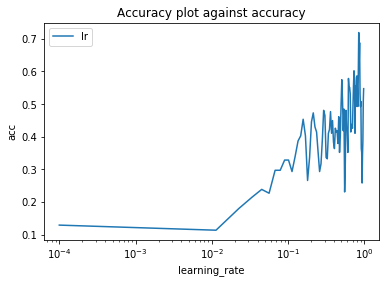

In [12]:
plt.plot(history['lr'],history['acc'])
plt.title('Accuracy plot against accuracy')
plt.xscale('log')
plt.xticks
plt.ylabel('acc')
plt.xlabel('learning_rate')
plt.legend(['lr'])
plt.show()

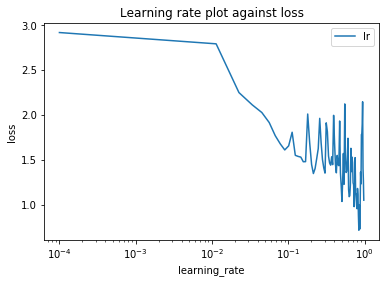

In [13]:
plt.plot(history['lr'],history['loss'])
plt.title('Learning rate plot against loss')
plt.xscale('log')
plt.ylabel('loss')
plt.xlabel('learning_rate')
plt.legend(['lr'])
plt.show()

By looking at the graph, the model starts converging when lr=0.02, so it is reasonable to set base lr = 0.02. Furthermore, above a learning rate of 0.09 the accuracy rise gets rough and eventually begins to drop so it is reasonable to set max lr = 0.09

In [14]:
clr = CyclicLR(base_lr=0.02, max_lr=0.09, step_size=np.ceil(X_train.shape[0]/(batch_size)), mode='triangular')

In [ ]:
history = model.fit(
   X_train[:train_size,:,:], 
   y_train_one_hot[:train_size,:], 
   epochs=20,
   batch_size=batch_size,
   callbacks=[clr],
   validation_data=(X_test[:test_size,:,:], y_test_one_hot[:test_size,:]) 
)

In [ ]:
# Save the model
model.save('models/sample.h5')